<a href="https://colab.research.google.com/github/nawroz-m/ML_learning/blob/main/04_transfer_learning_with_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow part 1: Feature Extraction
Transfer Learning is leveraging a working model's existing architecture and learn pattern for our own problem.
There are two main benefits:

1. Can leverage an existing Neural Network architecture proven to work on problem similar to our own.
2. Can leverage working Neural Network architecture which has already learned patterns on similar data to our own, then we can adapt those patern to our own data

In [ ]:
# Are we using GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Download the data

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-10-29 04:36:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.3MB/s    in 9.3s    

2025-10-29 04:36:24 (17.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import zipfile
import os

In [3]:
# unzip the file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [4]:
# Check all the files and folders
dataset_dir = '10_food_classes_10_percent'
for dirpath, dirnames, filenames in os.walk(dataset_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 10 director

In [5]:
import pathlib
import numpy as np

In [6]:
# Get classes
root_dir = pathlib.Path(os.path.join(dataset_dir, 'train'))
class_names = np.array(sorted([item.name for item in root_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [7]:
# Another way to get the classes
np.array(sorted(os.listdir(os.path.join(dataset_dir, 'train'))))

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [8]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

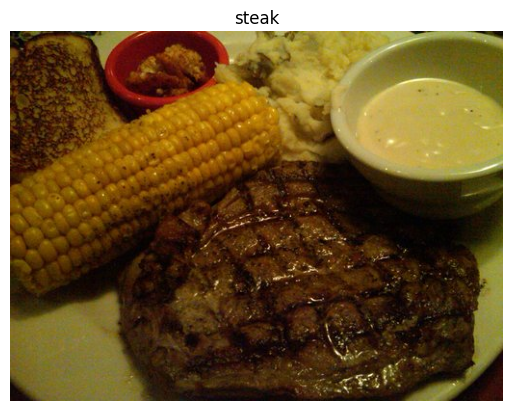

In [9]:
# plot a random image from a random class
# get a random class
random_class = random.choice(class_names)
# get a ranom image
images = os.listdir(os.path.join(dataset_dir, 'train', random_class))
random_image = random.choice(images)
# Get image data
img = mpimg.imread(os.path.join(dataset_dir, 'train', random_class, random_image))
#plot the image
plt.imshow(img)
plt.title(random_class)
plt.axis(False)

# Creating the data loader(Preparing the data)
Will use the `imageDataGenerator` to load the images in batches


In [10]:
!pip install tf_keras

In [11]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import tf_keras
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Get the dataset generator
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datgen = ImageDataGenerator(rescale=1/255.0)

In [14]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [15]:
# Prepare the dataset
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=42)
test_data =test_datgen.flow_from_directory(test_dir,
                                           target_size=(224,224),
                                           class_mode='categorical',
                                           batch_size=32,
                                           shuffle=True,
                                           seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
image, labels = next(train_data)
image[0].shape, labels[0].shape, len(train_data), len(test_data), 750/32

((224, 224, 3), (10,), 24, 79, 23.4375)

## Setting up callbacks (things to run while a model train)
Callbacks are extra functionality you can add to you models to be perfomed during or after training. Popular callbacks
* Tracking experiment with TensoreBoard callback
* Model checkpointing with ModelCheckPoint callback
* Stopping a model from training(before it train too long and overfitting) with EarlyStopping callback

In [16]:
from tensorflow.keras.callbacks import TensorBoard

In [17]:
# Create a TensorBoard callback
import datetime
def create_tensorbaord_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S"))
    print(log_dir)
    tensor_board_callback = tf_keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensor_board_callback

In [18]:
create_tensorbaord_callback('resnet', 'resnet_model')

resnet/resnet_model/2025-10-29-043738


# Creating a model using Tensorflow Hub

In [19]:
# Let's compare the following two model
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2'
efficientnet_url = 'https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2'

In [20]:
tf.__version__, hub.__version__, tf.keras.__version__

('2.19.0', '0.16.1', '3.10.0')

## Creating and testing Resnet Tensorflow Hub Feature Extraction model

In [22]:
IMAGE_SHAPE = (224, 224)

In [ ]:
# 1. Create a model
resnet_model = tf_keras.Sequential([
    hub.KerasLayer(resnet_url,
                   input_shape=IMAGE_SHAPE+(3,),
                   trainable=False,
                   name='feature_extraction_layer'),
    tf_keras.layers.Dense(10, activation='softmax')
])

In [ ]:
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# 2. Compile the model
resnet_model.compile(optimizer=tf_keras.optimizers.Adam(),
                     loss=tf_keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [ ]:
# 3. fit the model
resnet_history = resnet_model.fit(train_data, epochs=5,
                                  callbacks=[create_tensorbaord_callback('resnet_1', 'resnet_model')],
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  steps_per_epoch=len(train_data))

resnet_1/resnet_model/2025-10-27-080436
Epoch 1/5
24/24 [==============================] - 571s 24s/step - loss: 1.8260 - accuracy: 0.4040 - val_loss: 1.1407 - val_accuracy: 0.6520
Epoch 2/5
24/24 [==============================] - 524s 23s/step - loss: 0.9018 - accuracy: 0.7240 - val_loss: 0.8621 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 527s 23s/step - loss: 0.6413 - accuracy: 0.8213 - val_loss: 0.7595 - val_accuracy: 0.7460
Epoch 4/5
24/24 [==============================] - 528s 23s/step - loss: 0.4779 - accuracy: 0.8773 - val_loss: 0.6995 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 623s 27s/step - loss: 0.3864 - accuracy: 0.9133 - val_loss: 0.6639 - val_accuracy: 0.7788


Wow!
This much better then pure convolution layer untill I've build

<Axes: >

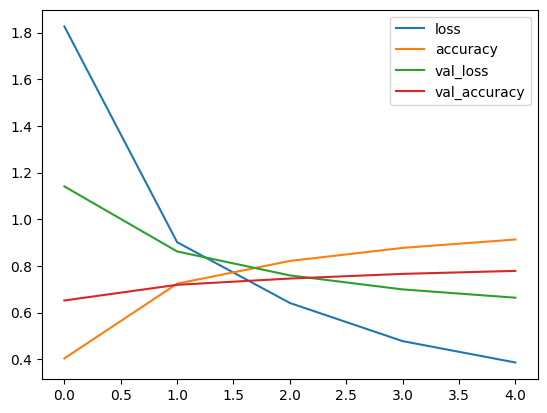

In [ ]:
# 4. Plot the loss curve
pd.DataFrame(resnet_history.history).plot()

**It's accuracy is pretty high but still it has overfitting which can be fixed by some overfitting tehcnics**

## Creating and testing Efficientnetb0 Tensorflow Hub Feature Extraction model

In [23]:
# Create Efficientnet feature extraction layer
efficient_feature_extraction_layer = hub.KerasLayer(efficientnet_url,
                                                    trainable=False,
                                                    name="Efficientnet_feature_extraction_layer",
                                                    input_shape=IMAGE_SHAPE+(3,))
# 1. create a mode
efficient_model = tf_keras.Sequential([
    efficient_feature_extraction_layer,
    tf_keras.layers.Dense(10, activation=tf_keras.activations.softmax)
])
# 2. Compile the model
efficient_model.compile(optimizer=tf_keras.optimizers.Adam(),
                        loss=tf_keras.losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])

In [24]:
# 3. Fit the efficient model
efficient_history = efficient_model.fit(train_data,
                                        epochs=5,
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        steps_per_epoch=len(train_data))

Epoch 1/5
24/24 [==============================] - 25s 577ms/step - loss: 1.9967 - accuracy: 0.3467 - val_loss: 1.5257 - val_accuracy: 0.5956
Epoch 2/5
24/24 [==============================] - 11s 486ms/step - loss: 1.3160 - accuracy: 0.6787 - val_loss: 1.1362 - val_accuracy: 0.7020
Epoch 3/5
24/24 [==============================] - 12s 511ms/step - loss: 1.0089 - accuracy: 0.7653 - val_loss: 0.9637 - val_accuracy: 0.7236
Epoch 4/5
24/24 [==============================] - 11s 496ms/step - loss: 0.8452 - accuracy: 0.8093 - val_loss: 0.8721 - val_accuracy: 0.7452
Epoch 5/5
24/24 [==============================] - 11s 464ms/step - loss: 0.7362 - accuracy: 0.8427 - val_loss: 0.7976 - val_accuracy: 0.7724


<Axes: >

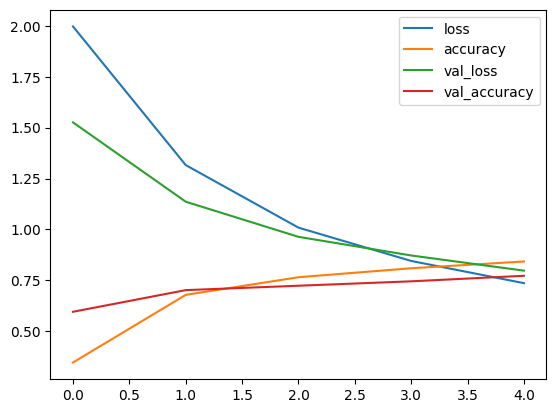

In [25]:
# Plot the efficientnet model loss curve
pd.DataFrame(efficient_history.history).plot()

<Axes: >

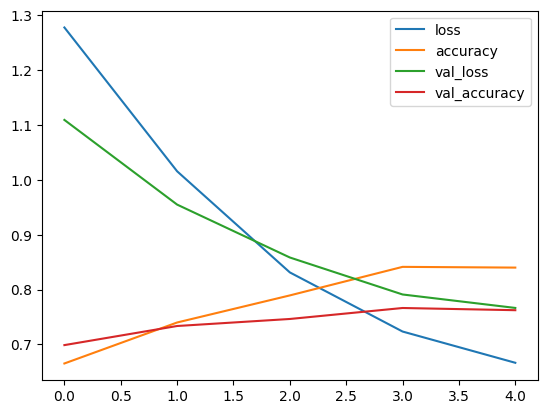

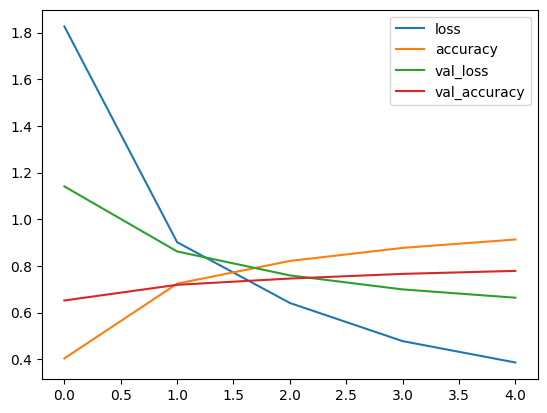

In [62]:
# Plot the efficient loss curve vs resnet loss curve
pd.DataFrame(efficient_history.history).plot()
pd.DataFrame(resnet_history.history).plot()

## Creating and testing Efficientnetb7 Tensorflow Hub Feature Extraction model

In [26]:
import tensorflow_hub as hub

In [33]:
tf_efficientnet_b7_url = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b7-feature-vector/1'
efficientnet_b7_feature_extraction_layer = hub.KerasLayer(tf_efficientnet_b7_url, trainable=False,
                                                          name="Efficientnet_b7_feature_extraction",
                                                          input_shape=IMAGE_SHAPE+(3,))

In [34]:
# 1. Create a model
efficientnet_b7_model = tf_keras.Sequential([
    efficientnet_b7_feature_extraction_layer,
    tf_keras.layers.Dense(10, activation=tf_keras.activations.softmax)
])

In [37]:
# 2. compile the model
efficientnet_b7_model.compile(optimizer=tf_keras.optimizers.Adam(),
                              loss=tf_keras.losses.CategoricalCrossentropy(),
                              metrics=['accuracy'])

In [36]:
# check the model summary
efficientnet_b7_model.summary()
efficient_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Efficientnet_b7_feature_ex  (None, 2560)              64097680  
 traction (KerasLayer)                                           
                                                                 
 dense_2 (Dense)             (None, 10)                25610     
                                                                 
Total params: 64123290 (244.61 MB)
Trainable params: 25610 (100.04 KB)
Non-trainable params: 64097680 (244.51 MB)
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Efficientnet_feature_extra  (None, 1280)              5919312   
 ction_layer (KerasLayer)                                        
                                                    

In [38]:
# 3. Fit the the efficientnet b7
efficientnet_b7_history = efficientnet_b7_model.fit(train_data,
                                                    epochs=5,
                                                    validation_data=test_data,
                                                    validation_steps=len(test_data),
                                                    steps_per_epoch=len(train_data),
                                                    callbacks=[create_tensorbaord_callback('efficientnet', 'b7')])

efficientnet/b7/2025-10-29-051234
Epoch 1/5
24/24 [==============================] - 80s 2s/step - loss: 1.5443 - accuracy: 0.5973 - val_loss: 0.9582 - val_accuracy: 0.8064
Epoch 2/5
24/24 [==============================] - 35s 2s/step - loss: 0.8082 - accuracy: 0.7987 - val_loss: 0.6599 - val_accuracy: 0.8396
Epoch 3/5
24/24 [==============================] - 35s 2s/step - loss: 0.5603 - accuracy: 0.8587 - val_loss: 0.5819 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 35s 1s/step - loss: 0.4856 - accuracy: 0.8880 - val_loss: 0.5101 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 35s 1s/step - loss: 0.4118 - accuracy: 0.9093 - val_loss: 0.5007 - val_accuracy: 0.8568


***Wow this is amazing***

<Axes: >

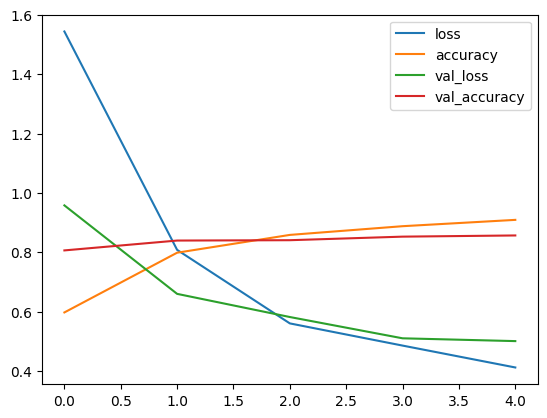

In [41]:
# Plot the efficientnet_b7 loss curve
pd.DataFrame(efficientnet_b7_history.history).plot()

In [46]:
# How many layers are in efficientnet b0 and b7 feature extraction
len(efficient_model.layers[0].weights), len(efficientnet_b7_model.layers[0].weights)

(359, 1035)